## Description
This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you **to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

## Evaluation
Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

Submission File

For each id in the test set, you must predict a total number of sales. The file should contain a header and have the following format:
```
ID,item_cnt_month
0,0.5
1,0.5
2,0.5
3,0.5
etc.
```

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.sparse import hstack
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from collections import deque
from datetime import datetime
import logging
import pprint as pp
import copy
import itertools 
from sklearn.model_selection import train_test_split
import pdb
from importlib import reload
import tensorflow as tf

pd.options.display.max_columns = None
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

kaggle/input/shops.csv
kaggle/input/test.csv.gz
kaggle/input/items.csv
kaggle/input/sales_train.csv.gz
kaggle/input/item_categories.csv
kaggle/input/sample_submission.csv.gz


In [2]:
items=pd.read_csv('kaggle/input/items.csv')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [3]:
# We are asking you to predict total sales for every product and store in the next month.
test=pd.read_csv('kaggle/input/test.csv.gz')
print(test.shape)
test.head()


(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
sample_submission=pd.read_csv('kaggle/input/sample_submission.csv.gz')
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [5]:
sales_train=pd.read_csv('kaggle/input/sales_train.csv.gz')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
item_categories=pd.read_csv('kaggle/input/item_categories.csv')
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
shops=pd.read_csv('kaggle/input/shops.csv')
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


## EDA

In [8]:
## Fixing data formats
sales_train['date_fixed']=pd.to_datetime(sales_train['date'],format='%d.%m.%Y')
sales_train['year']=sales_train['date_fixed'].dt.year
sales_train['month']=sales_train['date_fixed'].dt.month
sales_train['day']=sales_train['date_fixed'].dt.day
sales_train['year_month']=sales_train['date_fixed'].dt.year.astype(str)+'_'+sales_train['date_fixed'].dt.month.astype(str)

In [9]:
df = pd.merge(sales_train, items, on="item_id")

df = pd.merge(df, item_categories, on="item_category_id")

df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_fixed,year,month,day,year_month,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,2013-01-02,2013,1,2,2013_1,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,23.01.2013,0,24,22154,999.0,1.0,2013-01-23,2013,1,23,2013_1,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,20.01.2013,0,27,22154,999.0,1.0,2013-01-20,2013,1,20,2013_1,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,02.01.2013,0,25,22154,999.0,1.0,2013-01-02,2013,1,2,2013_1,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,03.01.2013,0,25,22154,999.0,1.0,2013-01-03,2013,1,3,2013_1,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


In [10]:
print(df.date.nunique())
assert df.date.nunique()==df.date_fixed.nunique()
print(df.date_fixed.min())
print(df.date_fixed.max())
print(df.shop_id.nunique())
print(df.item_id.nunique())


1034
2013-01-01 00:00:00
2015-10-31 00:00:00
60
21807


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 14 columns):
date                  object
date_block_num        int64
shop_id               int64
item_id               int64
item_price            float64
item_cnt_day          float64
date_fixed            datetime64[ns]
year                  int64
month                 int64
day                   int64
year_month            object
item_name             object
item_category_id      int64
item_category_name    object
dtypes: datetime64[ns](1), float64(2), int64(7), object(4)
memory usage: 336.0+ MB


In [12]:
df.describe() ## not useful

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,2.013777e+03,6.247717e+00,1.585267e+01,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,7.684790e-01,3.536219e+00,8.923483e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.013000e+03,3.000000e+00,8.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,2.014000e+03,6.000000e+00,1.600000e+01,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,2.014000e+03,9.000000e+00,2.400000e+01,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,2.015000e+03,1.200000e+01,3.100000e+01,8.300000e+01


### Item_cnt_day

In [13]:
display(pd.pivot_table(df,index=['shop_id','year'],columns='month',values='item_cnt_day',aggfunc=sum,margins=True))


month                1         2         3         4         5         6  \
shop_id year                                                               
0       2013    5578.0    6127.0       NaN       NaN       NaN       NaN   
1       2013    2947.0    3364.0       NaN       NaN       NaN       NaN   
2       2013    1146.0     488.0     753.0     583.0     553.0     832.0   
        2014     890.0     911.0     990.0     791.0     910.0     957.0   
        2015     987.0     907.0     762.0     859.0     843.0     804.0   
3       2013     767.0     798.0     959.0     647.0     710.0     784.0   
        2014     968.0     873.0    1105.0     685.0     776.0     828.0   
        2015     977.0     738.0     741.0     740.0     731.0     672.0   
4       2013    2114.0    2025.0    2060.0     285.0    1211.0    1464.0   
        2014    1430.0    1299.0    1246.0    1155.0    1324.0    1213.0   
        2015    1188.0     980.0     978.0     899.0     893.0     793.0   
5       2013       NaN     877.0    1355.0    1008.0    1110.0    1393.0   
        2014    1639.0    1252.0    1471.0    1055.0    1206.0    1326.0   
        2015    1404.0    1101.0    1109.0    1054.0    1012.0     954.0   
6       2013    3686.0    4007.0    4519.0    3168.0    3022.0    3847.0   
        2014    3024.0    3129.0    3105.0    3093.0    2620.0    2730.0   
        2015    2328.0    2329.0    1981.0    1998.0    1748.0    1539.0   
7       2013    2495.0    2513.0    2460.0    1540.0    1647.0    2085.0   
        2014    2349.0    2357.0    2032.0    1644.0    1675.0    1903.0   
        2015    2084.0    1847.0    1430.0    1340.0    1217.0    1235.0   
8       2013    1463.0    1156.0     977.0      -1.0       NaN       NaN   
9       2013       NaN       NaN       NaN       NaN       NaN       NaN   
        2014       NaN       NaN       NaN       NaN       NaN       NaN   
        2015       NaN       NaN       NaN      -1.0       NaN       NaN   
10      2013     935.0    1026.0    1017.0     756.0     683.0     764.0   
        2014     784.0     837.0     903.0     646.0     702.0     575.0   
        2015     628.0       NaN     565.0     594.0     466.0     441.0   
11      2015       NaN     572.0       NaN       NaN       NaN       NaN   
12      2013     842.0    1209.0    1419.0    1364.0     917.0    1710.0   
        2014    1103.0    1947.0    2165.0    1738.0    2040.0    1079.0   
...                ...       ...       ...       ...       ...       ...   
50      2014    3002.0    2891.0    2934.0    2143.0    1886.0    1722.0   
        2015    1437.0    1052.0     981.0     895.0    1073.0     900.0   
51      2013    2748.0    2284.0    2605.0    1945.0    2243.0    2200.0   
        2014    1623.0    1380.0    1582.0    1432.0    1226.0    1252.0   
        2015     976.0     660.0     545.0     494.0     758.0     659.0   
52      2013    1812.0    1737.0    2034.0    1446.0    1482.0    1815.0   
        2014    1625.0    1523.0    1741.0    1249.0    1338.0    1174.0   
        2015    1247.0    1117.0    1182.0    1152.0     894.0     820.0   
53      2013    2055.0    1906.0    2365.0    1515.0    1767.0    2125.0   
        2014    2144.0    1866.0    2059.0    1641.0    1731.0    1815.0   
        2015    1747.0    1342.0    1378.0    1322.0    1206.0    1078.0   
54      2013    9386.0    8075.0    9488.0    6726.0    7006.0    8101.0   
        2014    8198.0    6325.0    6876.0    5575.0    5593.0    6033.0   
        2015    6043.0    4221.0    4625.0     732.0       NaN       NaN   
55      2013       NaN       NaN       NaN       NaN     852.0     728.0   
        2014    1150.0    1067.0    1104.0    1271.0    1223.0    1355.0   
        2015    6429.0    2551.0    2769.0    3422.0    2117.0    1909.0   
56      2013    3238.0    2655.0    3099.0    2153.0    2140.0    3105.0   
        2014    2983.0    2347.0    2280.0    1655.0    1991.0    2583.0   
        2015    2444.0    1691.0    1393.0    12

In [14]:
display(pd.pivot_table(df[df.shop_id==2],index=['shop_id','item_id','year'],columns='month',values='item_cnt_day',aggfunc=sum,margins=True))

month                      1       2       3       4       5       6       7  \
shop_id item_id year                                                           
2       27      2013     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
                2014     NaN     NaN     NaN     NaN     NaN     1.0     NaN   
        30      2013     NaN     NaN     1.0     NaN     NaN     1.0     NaN   
                2014     NaN     NaN     NaN     1.0     1.0     NaN     NaN   
        31      2013     NaN     4.0     1.0     1.0     NaN     NaN     NaN   
                2014     NaN     NaN     NaN     NaN     1.0     NaN     NaN   
                2015     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
        32      2014     1.0     NaN     1.0     NaN     NaN     NaN     1.0   
                2015     NaN     NaN     1.0     NaN     NaN     NaN     NaN   
        33      2013     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
                2014     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
                2015     NaN     1.0     NaN     1.0     1.0     NaN     1.0   
        53      2015     NaN     1.0     NaN     NaN     NaN     NaN     NaN   
        59      2015     NaN     1.0     NaN     NaN     NaN     NaN     NaN   
        66      2014     NaN     NaN     NaN     NaN     1.0     NaN     NaN   
        67      2015     1.0     1.0     NaN     NaN     NaN     NaN     NaN   
        70      2015     NaN     NaN     NaN     1.0     NaN     NaN     NaN   
        76      2014     NaN     NaN     NaN     NaN     NaN     1.0     NaN   
        77      2014     NaN     NaN     NaN     NaN     NaN     1.0     NaN   
        97      2013     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
        99      2014     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
        257     2015     NaN     1.0     NaN     NaN     NaN     NaN     NaN   
        258     2015     NaN     1.0     NaN     NaN     NaN     NaN     NaN   
        317     2013     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
        438     2013     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
        464     2013     NaN     NaN     NaN     1.0     NaN     NaN     1.0   
                2014     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
                2015     NaN     NaN     NaN     NaN     2.0     NaN     NaN   
        471     2013     2.0     NaN     NaN     NaN     NaN     NaN     NaN   
        472     2013     NaN     NaN     NaN     NaN     NaN     1.0     3.0   
...                      ...     ...     ...     ...     ...     ...     ...   
        22087   2013     2.0     NaN     NaN     2.0     NaN     3.0     2.0   
                2014     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
                2015     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
        22088   2013     1.0     1.0     1.0     NaN     NaN     3.0     2.0   
                2014     NaN     NaN     NaN     NaN     NaN     NaN     3.0   
                2015     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
        22091   2013     1.0     NaN     NaN     NaN     NaN     NaN     NaN   
                2015     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
        22092   2013     4.0     NaN     NaN     2.0     NaN     NaN     1.0   
                2014     NaN     NaN     NaN     NaN     NaN     NaN     5.0   
                2015     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
        22095   2013     2.0     NaN     NaN     NaN     NaN     NaN     NaN   
        22099   2013     NaN     NaN     NaN     NaN     NaN     NaN     1.0   
        22100   2015     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
        22101   2015     NaN     NaN     NaN     NaN     NaN     NaN     1.0   
        22102   2015     NaN     NaN     NaN     NaN     8.0     6.0     3.0   
        22106   2014     NaN     NaN     NaN     NaN     NaN     NaN     NaN   


Does not look like seasonality. Very sparse

In [15]:
display(pd.pivot_table(df,index=['item_id','year'],columns='month',values='item_cnt_day',aggfunc=sum,margins=True))

,month,1,2,3,4,5,6,7,8,9,10,11,12,All
item_id,year,,,,,,,,,,,,,
0,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
1,2014,NaN,NaN,NaN,2.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,6.0
2,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,2.0
3,2014,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,2.0
4,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
5,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
6,2014,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
7,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
8,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,2.0


Some shops are not selling products after 2013. Item level data is very sparse and some products are sold only once throughout the years. 

> May have to clip values

In [16]:
print(df.item_price.max())
df.item_price.min()

307980.0


-1.0

In [17]:
bin_values = np.arange(start=-50, stop=df.item_price.max()//10, step=100)
## Removing very high price values


In [18]:
df[df.year==2013].item_price.hist(bins=bin_values, figsize=[14,6])

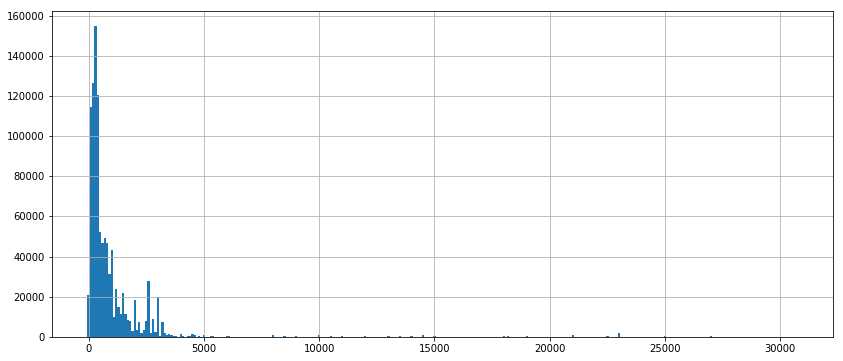

In [19]:
df[df.year==2014].item_price.hist(bins=bin_values, figsize=[14,6])

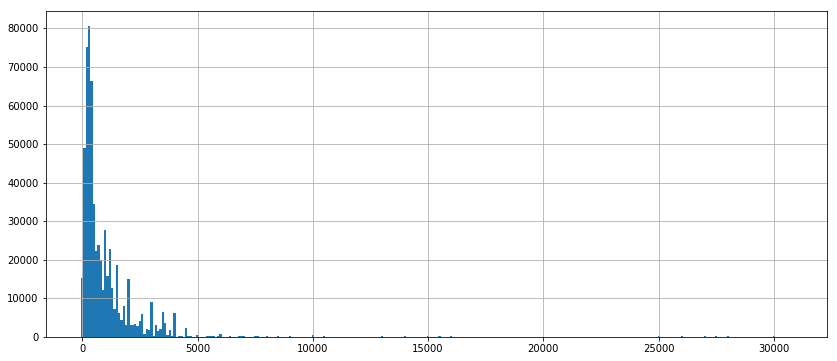

In [20]:
df[df.year==2015].item_price.hist(bins=bin_values, figsize=[14,6])

Looks like price dropped in year 2015. There is data anomoly with negative price value as well 

# Train vs Test Data Comparison
# Distribution Approximation

In [21]:
sales_train.head(1).T

,0
date,02.01.2013
date_block_num,0
shop_id,59
item_id,22154
item_price,999
item_cnt_day,1
date_fixed,2013-01-02 00:00:00
year,2013
month,1
day,2


In [22]:
### fixing price issue
# sales_train=sales_train[sales_train['item_price']>=0]

In [23]:
# sales_train=sales_train[(sales_train.item_price<100000)&(sales_train.item_cnt_day<=900)]

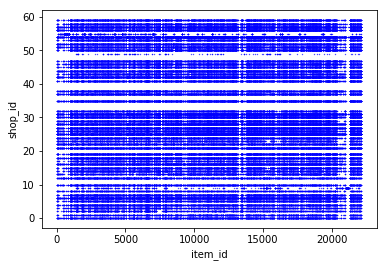

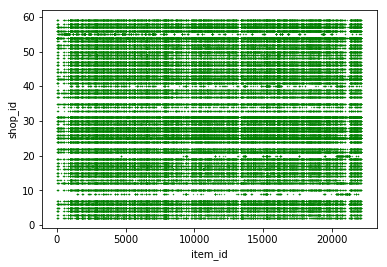

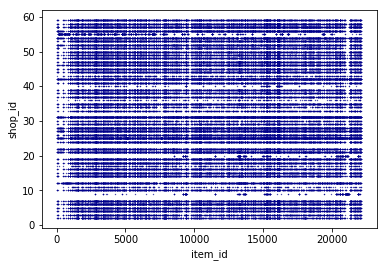

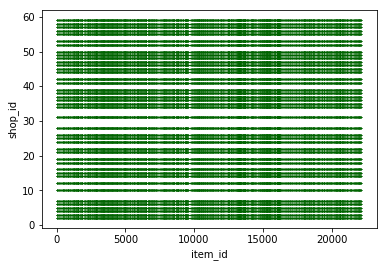

In [24]:
sales_train[sales_train.year==2013].drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='Blue', s = 0.1)
sales_train[sales_train.year==2014].drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='Green', s = 0.1)
sales_train[sales_train.year==2015].drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkBlue', s = 0.1)
test.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkGreen', s = 0.1)

Some shops id are not present in test data. Distribution looks similar for 2014/2015 and test data. Better not to use 2013 for training. May also help to mitigate risk due to price drop


In [25]:
## Boiler plate code for cartesian product - Kazanova video
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

#Compute all shops/items combinations
grid = []
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train.loc[sales_train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales_train.loc[sales_train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [26]:
print(grid.shape)
grid.head()

(10913850, 3)


,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [29]:
sales_train_month = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()

In [30]:
sales_train_month = pd.merge(grid,sales_train_month,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)

In [31]:
sales_train_month.shape

(10913850, 5)

In [32]:
sales_train_month = pd.merge(sales_train_month,items,on=['item_id'],how='left')

In [33]:
sales_train_month.shape

(10913850, 7)

In [34]:
sales_train_month = pd.merge(sales_train_month,item_categories, on=['item_category_id'], how='left')

In [35]:
sales_train_month.shape

(10913850, 8)

In [36]:
sales_train_month.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_category_name
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео


In [37]:
print(test.shape)
test.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [38]:
## Populating other fields in test
test_copy=test.copy()
test_copy.drop('ID', axis=1, inplace=True)
print(test_copy.shape)

(214200, 2)


In [39]:
test_copy['date_block_num'] = sales_train_month.date_block_num.max()+1
# test_copy['item_cnt_day'] - to be predicted
test_copy = pd.merge(test_copy,\
                     df[['item_id','item_name','item_category_id','item_category_name']]\
                     .drop_duplicates(),on='item_id',how='left')
## not using price as price is changing with time
print(test_copy.shape)
test_copy.head()

(214200, 6)


,shop_id,item_id,date_block_num,item_name,item_category_id,item_category_name
0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19.0,Игры - PS3
1,5,5320,34,NaN,NaN,NaN
2,5,5233,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19.0,Игры - PS3
3,5,5232,34,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23.0,Игры - XBOX 360
4,5,5268,34,NaN,NaN,NaN


A lot of unseen data present in test dataset. Doing simplest possible missing value treatment 

In [40]:
print(test_copy.isnull().sum())
print(test_copy.shape)
print(test_copy.columns)

shop_id                   0
item_id                   0
date_block_num            0
item_name             15246
item_category_id      15246
item_category_name    15246
dtype: int64
(214200, 6)
Index(['shop_id', 'item_id', 'date_block_num', 'item_name', 'item_category_id',
       'item_category_name'],
      dtype='object')


> Need to fix the missing value in the test dataset as we will be creating lag features in one loop all the weeks

In [41]:
## replacing missing values with mode of the column
for col in ['item_name','item_category_id','item_category_name']:
    test_copy[col]=test_copy[col].fillna(test_copy[col].mode()[0])
    
print(test_copy.isnull().sum())
print(test_copy.shape)

shop_id               0
item_id               0
date_block_num        0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64
(214200, 6)


### Appending both test and train dataset

In [45]:
sales_train_month=sales_train_month.append(test_copy)

/home/prateek/anaconda3/envs/IntroToTensorFlow/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [46]:
### Mean encoding for categorical variables - simplest mean encoding - could be data leakage. 
for type_id in ['item_id','shop_id','item_category_id']: #for the three categorical variables
    for column_id, agg_func, func_name in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:

        mean_df = sales_train_month.groupby([type_id,'date_block_num']).agg(agg_func).reset_index()[[column_id,type_id,'date_block_num']]
        ### encoding with mean value of the data block
        mean_df.columns = [type_id+'_'+func_name+'_'+column_id, type_id,'date_block_num']
        
        sales_train_month = pd.merge(sales_train_month,mean_df,on=['date_block_num', type_id],how='left')

IMP: For test dataset, drop all the current week numbers. Use only lag features

In [47]:
sales_train_month[sales_train_month.date_block_num==34].head()

,date_block_num,item_category_id,item_category_name,item_cnt_day,item_id,item_name,item_price,shop_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
10913850,34,19.0,Игры - PS3,NaN,5037,"NHL 15 [PS3, русские субтитры]",NaN,5,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN
10913851,34,40.0,Кино - DVD,NaN,5320,007: КООРДИНАТЫ «СКАЙФОЛЛ»,NaN,5,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN
10913852,34,19.0,Игры - PS3,NaN,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",NaN,5,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN
10913853,34,23.0,Игры - XBOX 360,NaN,5232,"Need for Speed Rivals (Classics) [Xbox 360, ру...",NaN,5,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN
10913854,34,40.0,Кино - DVD,NaN,5268,007: КООРДИНАТЫ «СКАЙФОЛЛ»,NaN,5,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN


In [48]:
sales_train_month.shape

(11128050, 17)

In [49]:
sales_train_month.head()

,date_block_num,item_category_id,item_category_name,item_cnt_day,item_id,item_name,item_price,shop_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,0,37.0,Кино - Blu-Ray,1.0,22154,ЯВЛЕНИЕ 2012 (BD),999.0,59,310.800000,18.0,0.400000,97.974472,2017.0,0.248552,63.014719,6094.0,0.199738
1,0,58.0,Музыка - Винил,0.0,2552,DEEP PURPLE The House Of Blue Light LP,0.0,59,19.977778,0.0,0.000000,97.974472,2017.0,0.248552,54.898665,287.0,0.043386
2,0,58.0,Музыка - Винил,0.0,2554,DEEP PURPLE Who Do You Think We Are LP,0.0,59,37.978889,1.0,0.022222,97.974472,2017.0,0.248552,54.898665,287.0,0.043386
3,0,56.0,Музыка - CD фирменного производства,0.0,2555,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),0.0,59,48.837778,2.0,0.044444,97.974472,2017.0,0.248552,38.267019,268.0,0.049630
4,0,59.0,Музыка - Музыкальное видео,0.0,2564,DEEP PURPLE Perihelion: Live In Concert DVD (К...,0.0,59,36.400000,5.0,0.111111,97.974472,2017.0,0.248552,35.593867,701.0,0.093280


In [101]:
### how to get the lag values for test dataset- all columns will have to renamed.. 
### plus some value will be from validation dataset, while remaining columns will be from training dataset

### data is inverted right triangle..loop within loop? 
### plus data block num is dropped

In [51]:
lag_variables  = ['item_id_avg_item_price',
'item_id_sum_item_cnt_day',
'item_id_avg_item_cnt_day',
'shop_id_avg_item_price',
'shop_id_sum_item_cnt_day',
'shop_id_avg_item_cnt_day',
'item_category_id_avg_item_price',
'item_category_id_sum_item_cnt_day',
'item_category_id_avg_item_cnt_day',
'item_cnt_day']


lags = [1,2,3,4,5,6,7] #ideally, rolling window should have given good approximation. As kaggle kernel is crashing, focusing only previous day and previous week values.
## lag of 8,31 is killing the kernel
## 16 gb ram not enough
## ordered 32 GB Ram from AMAZON
for lag in lags:
    sales_new_df = sales_train_month.copy() ### unfortunate -- but test has to be processed here
    sales_new_df.date_block_num+=lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    print("Lag {} ".format(str(lag)))
    print(sales_new_df.columns)
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    print(sales_new_df.columns)
    ### merging it back
    sales_train_month = sales_train_month.merge(sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

Lag 1 
Index(['date_block_num', 'shop_id', 'item_id', 'item_id_avg_item_price',
       'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day',
       'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day',
       'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_avg_item_cnt_day', 'item_cnt_day'],
      dtype='object')
Index(['date_block_num', 'shop_id', 'item_id', 'item_id_avg_item_price_lag_1',
       'item_id_sum_item_cnt_day_lag_1', 'item_id_avg_item_cnt_day_lag_1',
       'shop_id_avg_item_price_lag_1', 'shop_id_sum_item_cnt_day_lag_1',
       'shop_id_avg_item_cnt_day_lag_1',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_sum_item_cnt_day_lag_1',
       'item_category_id_avg_item_cnt_day_lag_1', 'item_cnt_day_lag_1'],
      dtype='object')
Lag 2 
Index(['date_block_num', 'shop_id', 'item_id', 'item_id_avg_item_price',
       'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_d

In [52]:
sales_train_month[(sales_train_month.date_block_num==34)\
                  &(sales_train_month.item_id==5037)\
                 &(sales_train_month.shop_id==5)]

,date_block_num,item_category_id,item_category_name,item_cnt_day,item_id,item_name,item_price,shop_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_id_avg_item_price_lag_2,item_id_sum_item_cnt_day_lag_2,item_id_avg_item_cnt_day_lag_2,shop_id_avg_item_price_lag_2,shop_id_sum_item_cnt_day_lag_2,shop_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_id_avg_item_price_lag_3,item_id_sum_item_cnt_day_lag_3,item_id_avg_item_cnt_day_lag_3,shop_id_avg_item_price_lag_3,shop_id_sum_item_cnt_day_lag_3,shop_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3,item_id_avg_item_price_lag_4,item_id_sum_item_cnt_day_lag_4,item_id_avg_item_cnt_day_lag_4,shop_id_avg_item_price_lag_4,shop_id_sum_item_cnt_day_lag_4,shop_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4,item_id_avg_item_price_lag_5,item_id_sum_item_cnt_day_lag_5,item_id_avg_item_cnt_day_lag_5,shop_id_avg_item_price_lag_5,shop_id_sum_item_cnt_day_lag_5,shop_id_avg_item_cnt_day_lag_5,item_category_id_avg_item_price_lag_5,item_category_id_sum_item_cnt_day_lag_5,item_category_id_avg_item_cnt_day_lag_5,item_cnt_day_lag_5,item_id_avg_item_price_lag_6,item_id_sum_item_cnt_day_lag_6,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6,item_id_avg_item_price_lag_7,item_id_sum_item_cnt_day_lag_7,item_id_avg_item_cnt_day_lag_7,shop_id_avg_item_price_lag_7,shop_id_sum_item_cnt_day_lag_7,shop_id_avg_item_cnt_day_lag_7,item_category_id_avg_item_price_lag_7,item_category_id_sum_item_cnt_day_lag_7,item_category_id_avg_item_cnt_day_lag_7,item_cnt_day_lag_7
10913850,34,19.0,Игры - PS3,NaN,5037,"NHL 15 [PS3, русские субтитры]",NaN,5,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,579.159091,25.0,0.568182,111.209795,1052.0,0.194347,355.122549,2443.0,0.380293,0.0,627.844449,110.0,2.55814,123.394584,1092.0,0.214749,329.15195,3979.0,0.585664,1.0,787.18056,119.0,2.833333,130.951613,1294.0,0.253328,340.806763,4667.0,0.673449,3.0,967.022326,54.0,1.255814,101.017801,991.0,0.186173,359.61808,3178.0,0.447921,1.0,970.594168,105.0,2.44186,98.051074,954.0,0.182899,347.692972,3487.0,0.49447,1.0,1202.773106,87.0,1.977273,103.231186,1012.0,0.191558,344.761915,3392.0,0.450824,1.0,1271.851064,28.0,0.595745,85.99833,1054.0,0.192476,319.51021,2779.0,0.330322,0.0


item_id_avg_item_price_lag_1 = 579.159091

item_id_avg_item_price_lag_2 = 627.844449

In [53]:
sales_train_month[(sales_train_month.date_block_num==33)\
                  &(sales_train_month.item_id==5037)\
                 &(sales_train_month.shop_id==5)]

,date_block_num,item_category_id,item_category_name,item_cnt_day,item_id,item_name,item_price,shop_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_id_avg_item_price_lag_2,item_id_sum_item_cnt_day_lag_2,item_id_avg_item_cnt_day_lag_2,shop_id_avg_item_price_lag_2,shop_id_sum_item_cnt_day_lag_2,shop_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_id_avg_item_price_lag_3,item_id_sum_item_cnt_day_lag_3,item_id_avg_item_cnt_day_lag_3,shop_id_avg_item_price_lag_3,shop_id_sum_item_cnt_day_lag_3,shop_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3,item_id_avg_item_price_lag_4,item_id_sum_item_cnt_day_lag_4,item_id_avg_item_cnt_day_lag_4,shop_id_avg_item_price_lag_4,shop_id_sum_item_cnt_day_lag_4,shop_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4,item_id_avg_item_price_lag_5,item_id_sum_item_cnt_day_lag_5,item_id_avg_item_cnt_day_lag_5,shop_id_avg_item_price_lag_5,shop_id_sum_item_cnt_day_lag_5,shop_id_avg_item_cnt_day_lag_5,item_category_id_avg_item_price_lag_5,item_category_id_sum_item_cnt_day_lag_5,item_category_id_avg_item_cnt_day_lag_5,item_cnt_day_lag_5,item_id_avg_item_price_lag_6,item_id_sum_item_cnt_day_lag_6,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6,item_id_avg_item_price_lag_7,item_id_sum_item_cnt_day_lag_7,item_id_avg_item_cnt_day_lag_7,shop_id_avg_item_price_lag_7,shop_id_sum_item_cnt_day_lag_7,shop_id_avg_item_cnt_day_lag_7,item_category_id_avg_item_price_lag_7,item_category_id_sum_item_cnt_day_lag_7,item_category_id_avg_item_cnt_day_lag_7,item_cnt_day_lag_7
10849431,33,19.0,Игры - PS3,0.0,5037,"NHL 15 [PS3, русские субтитры]",0.0,5,579.159091,25.0,0.568182,111.209795,1052.0,0.194347,355.122549,2443.0,0.380293,627.844449,110.0,2.55814,123.394584,1092.0,0.214749,329.15195,3979.0,0.585664,1.0,787.18056,119.0,2.833333,130.951613,1294.0,0.253328,340.806763,4667.0,0.673449,3.0,967.022326,54.0,1.255814,101.017801,991.0,0.186173,359.61808,3178.0,0.447921,1.0,970.594168,105.0,2.44186,98.051074,954.0,0.182899,347.692972,3487.0,0.49447,1.0,1202.773106,87.0,1.977273,103.231186,1012.0,0.191558,344.761915,3392.0,0.450824,1.0,1271.851064,28.0,0.595745,85.99833,1054.0,0.192476,319.51021,2779.0,0.330322,0.0,1356.0,31.0,0.673913,93.402133,1109.0,0.182341,379.97393,3737.0,0.429837,0.0


item_id_avg_item_price = 579.159091

item_id_avg_item_price_lag_1 = 627.844449

Looks like test dataset is correctly populated for lag values, though there are missing values.What to do with them?

In [54]:
## test, item_cnt will be zero/unknown. Due to cartesian product and creation of grid, some values will be nan
for col in sales_train_month.columns:
    if 'item_cnt' in col:
        sales_train_month[col]=sales_train_month[col].fillna(0)
    elif 'item_price' in col: ## most likely, not going to use this columns  
        ## as validation dataset and test dataset may have huge price volatility
        sales_train_month[col]=sales_train_month[col].fillna(sales_train_month[col].median())

In [55]:
print(len(sales_train_month.columns))
sales_train_month.columns

87


Index(['date_block_num', 'item_category_id', 'item_category_name',
       'item_cnt_day', 'item_id', 'item_name', 'item_price', 'shop_id',
       'item_id_avg_item_price', 'item_id_sum_item_cnt_day',
       'item_id_avg_item_cnt_day', 'shop_id_avg_item_price',
       'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day',
       'item_category_id_avg_item_price', 'item_category_id_sum_item_cnt_day',
       'item_category_id_avg_item_cnt_day', 'item_id_avg_item_price_lag_1',
       'item_id_sum_item_cnt_day_lag_1', 'item_id_avg_item_cnt_day_lag_1',
       'shop_id_avg_item_price_lag_1', 'shop_id_sum_item_cnt_day_lag_1',
       'shop_id_avg_item_cnt_day_lag_1',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_sum_item_cnt_day_lag_1',
       'item_category_id_avg_item_cnt_day_lag_1', 'item_cnt_day_lag_1',
       'item_id_avg_item_price_lag_2', 'item_id_sum_item_cnt_day_lag_2',
       'item_id_avg_item_cnt_day_lag_2', 'shop_id_avg_item_price_lag_2',
       'shop_id_

In [56]:
### Heavy Data Leakage - validation score is under 0.4, while public leader board shows a score of 8+
## dropping everything apart from lag features - converting it into a rolling window problem
selected_columns=['item_price','item_name','item_category_id','item_category_name',
                 'item_id_avg_item_price',
                'item_id_sum_item_cnt_day',
                'item_id_avg_item_cnt_day',
                'shop_id_avg_item_price',
                'shop_id_sum_item_cnt_day',
                'shop_id_avg_item_cnt_day',
                'item_category_id_avg_item_price',
                'item_category_id_sum_item_cnt_day',
                'item_category_id_avg_item_cnt_day',
                ]
## cannot drop date_block_num as it is required for creating the validaiton dataset
## price is too volatile for some of the items. so, it can happen the day, the last month median price kept
## for updating the test dataset may be far off from the unseen correct values

In [57]:
sales_train_month=sales_train_month.drop(columns=selected_columns)

In [58]:
print(len(sales_train_month.columns))
sales_train_month.columns
      

74


Index(['date_block_num', 'item_cnt_day', 'item_id', 'shop_id',
       'item_id_avg_item_price_lag_1', 'item_id_sum_item_cnt_day_lag_1',
       'item_id_avg_item_cnt_day_lag_1', 'shop_id_avg_item_price_lag_1',
       'shop_id_sum_item_cnt_day_lag_1', 'shop_id_avg_item_cnt_day_lag_1',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_sum_item_cnt_day_lag_1',
       'item_category_id_avg_item_cnt_day_lag_1', 'item_cnt_day_lag_1',
       'item_id_avg_item_price_lag_2', 'item_id_sum_item_cnt_day_lag_2',
       'item_id_avg_item_cnt_day_lag_2', 'shop_id_avg_item_price_lag_2',
       'shop_id_sum_item_cnt_day_lag_2', 'shop_id_avg_item_cnt_day_lag_2',
       'item_category_id_avg_item_price_lag_2',
       'item_category_id_sum_item_cnt_day_lag_2',
       'item_category_id_avg_item_cnt_day_lag_2', 'item_cnt_day_lag_2',
       'item_id_avg_item_price_lag_3', 'item_id_sum_item_cnt_day_lag_3',
       'item_id_avg_item_cnt_day_lag_3', 'shop_id_avg_item_price_lag_3',
       's

In [59]:
## Dropping categorical columns as mean coding is already present
# sales_train_month=sales_train_month.drop(columns=['item_name','item_category_name','item_category_id'])

In [60]:
## as found in the comparison chart, not using 2013 values for training
### how to deal with lag of 15 days or 3 weeks 


### -- values before this, we are trying to avoid
sales_train_month = sales_train_month[sales_train_month['date_block_num']>12]


In [61]:
## too many self joins - check _x is not coming
sales_train_month[sales_train_month['date_block_num']<33]\
.drop(columns=['item_cnt_day','date_block_num','shop_id','item_id']).columns

Index(['item_id_avg_item_price_lag_1', 'item_id_sum_item_cnt_day_lag_1',
       'item_id_avg_item_cnt_day_lag_1', 'shop_id_avg_item_price_lag_1',
       'shop_id_sum_item_cnt_day_lag_1', 'shop_id_avg_item_cnt_day_lag_1',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_sum_item_cnt_day_lag_1',
       'item_category_id_avg_item_cnt_day_lag_1', 'item_cnt_day_lag_1',
       'item_id_avg_item_price_lag_2', 'item_id_sum_item_cnt_day_lag_2',
       'item_id_avg_item_cnt_day_lag_2', 'shop_id_avg_item_price_lag_2',
       'shop_id_sum_item_cnt_day_lag_2', 'shop_id_avg_item_cnt_day_lag_2',
       'item_category_id_avg_item_price_lag_2',
       'item_category_id_sum_item_cnt_day_lag_2',
       'item_category_id_avg_item_cnt_day_lag_2', 'item_cnt_day_lag_2',
       'item_id_avg_item_price_lag_3', 'item_id_sum_item_cnt_day_lag_3',
       'item_id_avg_item_cnt_day_lag_3', 'shop_id_avg_item_price_lag_3',
       'shop_id_sum_item_cnt_day_lag_3', 'shop_id_avg_item_cnt_day_lag_3

In [62]:
## Clipping as per the evaluation rules
sales_train_month['item_cnt_day'].clip_upper(40, inplace=True)
sales_train_month['item_cnt_day'].clip_lower(0, inplace=True)
X_train=sales_train_month[sales_train_month['date_block_num']<33]\
.drop(columns=['item_cnt_day','date_block_num','shop_id','item_id']).values
y_train=sales_train_month[sales_train_month['date_block_num']<33]['item_cnt_day']

/home/prateek/anaconda3/envs/IntroToTensorFlow/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  
/home/prateek/anaconda3/envs/IntroToTensorFlow/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
X_validation =  sales_train_month[sales_train_month['date_block_num']==33]\
.drop(columns=['item_cnt_day','date_block_num','shop_id','item_id']).values
y_validation=sales_train_month[sales_train_month['date_block_num']==33]['item_cnt_day'].values

In [64]:
X_test =  sales_train_month[sales_train_month['date_block_num']==34]\
.drop(columns=['item_cnt_day','date_block_num','shop_id','item_id']).values


### Training

In [65]:
import xgboost as xgb


In [66]:
# https://www.kdnuggets.com/2017/03/simple-xgboost-tutorial-iris-dataset.html
# from sklearn import datasets

# iris = datasets.load_iris()
# X = iris.data
# y = iris.target
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# import xgboost as xgb

# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)
# param = {
#     'max_depth': 3,  # the maximum depth of each tree
#     'eta': 0.3,  # the training step for each iteration
#     'silent': 1,  # logging mode - quiet
#     'objective': 'multi:softprob',  # error evaluation for multiclass training
#     'num_class': 3}  # the number of classes that exist in this datset
# num_round = 20  # the number of training iterations
# bst = xgb.train(param, dtrain, num_round)
# bst.dump_model('dump.raw.txt')
# preds = bst.predict(dtest)
# preds

In [97]:
### dropping columns - item_cnt

# https://xgboost.readthedocs.io/en/latest/get_started.html

params = {'max_depth':10, ### too much depth
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.09, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

In [98]:
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_test.shape)

(6186922, 70)
(6186922,)
(238172, 70)
(238172,)
(214200, 70)


In [99]:

watchlist = [(xgb.DMatrix(X_train, y_train), 'train'),\
             (xgb.DMatrix(X_validation, y_validation), 'valid')]

In [100]:
model = xgb.train(params, xgb.DMatrix(X_train, y_train),\
                  3500,  watchlist, maximize=False,\
                  verbose_eval=2, early_stopping_rounds=50)

[23:08:17] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-rmse:1.39524	valid-rmse:1.37493
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[2]	train-rmse:1.29747	valid-rmse:1.31101
[4]	train-rmse:1.23056	valid-rmse:1.26588
[6]	train-rmse:1.1778	valid-rmse:1.23409
[8]	train-rmse:1.13732	valid-rmse:1.21216
[10]	train-rmse:1.10912	valid-rmse:1.19714
[12]	train-rmse:1.08586	valid-rmse:1.18624
[14]	train-rmse:1.06967	valid-rmse:1.1793
[16]	train-rmse:1.05651	valid-rmse:1.17421
[18]	train-rmse:1.04637	valid-rmse:1.17151
[20]	train-rmse:1.03848	valid-rmse:1.16943
[22]	train-rmse:1.03214	valid-rmse:1.16812
[24]	train-rmse:1.02662	valid-rmse:1.16699
[26]	train-rmse:1.02171	valid-rmse:1.16701
[28]	train-rmse:1.01733	valid-rmse:1.16688
[30]	train-rms

In [102]:
## saving the model on hard drive
import pickle
pickle.dump(model, open("model.pickle", "wb"))

In [103]:
model = pickle.load(open("model.pickle", "rb"))

In [104]:
print("Model Reloaded")

Model Reloaded


In [111]:
pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
pred = pred.clip(0,20) ## as per evaluation guidelines - read from kernels that 40 may improve score
test['item_cnt_month']=pred

In [112]:
### checking how the distribution is changing on modifying the training parameters
pd.Series(pred).describe()

count    214200.000000
mean          0.295561
std           0.741966
min           0.000000
25%           0.034267
50%           0.118909
75%           0.375157
max          20.000000
dtype: float64

In [113]:
Submission=test[['item_cnt_month']]
Submission=Submission.reset_index()
Submission.columns=['ID','item_cnt_month']
Submission.to_csv('submission.csv',index=False)

In [114]:
print("Completed")

Completed


In [115]:
### Checking submission file data
pd.read_csv('submission.csv').head()

,ID,item_cnt_month
0,0,0.342671
1,1,0.489332
2,2,0.989546
3,3,1.107322
4,4,0.489332
